In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

### Data

In [5]:
# MNIST IMAGE --> Tensors
transform = transforms.ToTensor()

In [6]:
train_data = datasets.MNIST(root="./Data", train=True, download=True, transform=transform)

In [7]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [8]:
test_data = datasets.MNIST(root="./Data", train=False, download=True, transform=transform)

In [10]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [11]:
type(train_data)

torchvision.datasets.mnist.MNIST

In [16]:
image, label = train_data[0]

In [17]:
image.shape

torch.Size([1, 28, 28])

In [18]:
label

5

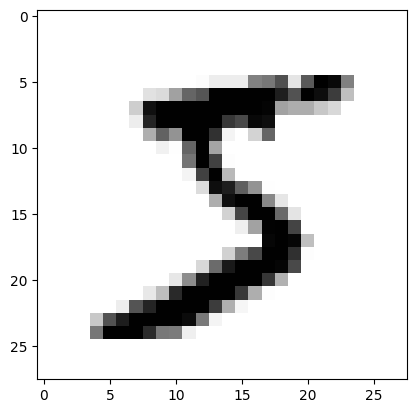

In [23]:
plt.imshow(image.reshape((28,28)), cmap="gist_yarg") 

In [34]:
torch.manual_seed(101)

# 0 images, 1 images
train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
test_loader = DataLoader(test_data, batch_size=500,  shuffle=False)

In [35]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x : f"{x:4}")) # Formatting

In [36]:
# First Batch
for images, labels in train_loader :
    break

In [37]:
images.shape

torch.Size([100, 1, 28, 28])

In [38]:
labels.shape

torch.Size([100])

Labels:  [   7    2    3    5    8    5    3    6    9    9    1    3]


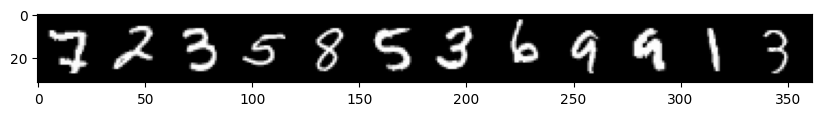

In [39]:
print('Labels: ', labels[:12].numpy())

# Print the first 12 images
im = make_grid(images[:12], nrow=12)  # the default nrow is 8
plt.figure(figsize=(10,4))
# We need to transpose the images from CWH to WHC
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

### Create Network(Model)

In [55]:
class MultilayerPerceptron(nn.Module):

    def __init__(self, in_sz=784, out_sz=10, layers=[120, 84]):
        
        super().__init__()

        self.fc1 = nn.Linear(in_sz, layers[0])
        self.fc2 = nn.Linear(layers[0], layers[1])
        self.fc3 = nn.Linear(layers[1], out_sz)

    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1) # Multi Class Classification

In [56]:
torch.manual_seed(101)
model = MultilayerPerceptron()
model

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [57]:
# ANN ---> CNN
for param in model.parameters():
    print(param.numel())

94080
120
10080
84
840
10


In [58]:
# 105,214 total parameters

### Training

In [59]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [60]:
images.shape # ----> [100, 784]

torch.Size([100, 1, 28, 28])

In [61]:
images.view(100, -1).shape

torch.Size([100, 784])

In [62]:
import time
start_time = time.time()

# Training
epochs = 10

# Trackers
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    for b, (X_train, y_train) in enumerate(train_loader):
        
        b += 1
        
        y_pred = model(X_train.view(100,-1))
        loss = criterion(y_pred, y_train)
        
        # 10 Neurons  [0.1, 0.0, ..., 0.8]
        predicted = torch.max(y_pred.data, 1)[1] 
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b%200 == 0:
            acc = trn_corr.item()*100/(100*b)
            print(f"Epoch {i} batch {b} loss: {loss.item()} accuracy: {acc}")
        
    train_losses.append(loss)
    train_correct.append(trn_corr)

    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test.view(500, -1))

            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted==y_test).sum()

        loss = criterion(y_val, y_test)
        test_losses.append(loss)
        test_correct.append(tst_corr)



total_time = time.time() - start_time
print(f"Duration : {total_time/60} min")

Epoch 0 batch 200 loss: 0.23562383651733398 accuracy: 83.245
Epoch 0 batch 400 loss: 0.353285551071167 accuracy: 87.5325
Epoch 0 batch 600 loss: 0.13676533102989197 accuracy: 89.57833333333333
Epoch 1 batch 200 loss: 0.24926894903182983 accuracy: 94.845
Epoch 1 batch 400 loss: 0.1481877565383911 accuracy: 95.0775
Epoch 1 batch 600 loss: 0.07620131224393845 accuracy: 95.36
Epoch 2 batch 200 loss: 0.08650680631399155 accuracy: 96.57
Epoch 2 batch 400 loss: 0.06262712180614471 accuracy: 96.6575
Epoch 2 batch 600 loss: 0.06496364623308182 accuracy: 96.72833333333334
Epoch 3 batch 200 loss: 0.11511605978012085 accuracy: 97.655
Epoch 3 batch 400 loss: 0.05642367899417877 accuracy: 97.485
Epoch 3 batch 600 loss: 0.03264883905649185 accuracy: 97.51333333333334
Epoch 4 batch 200 loss: 0.11097180098295212 accuracy: 98.095
Epoch 4 batch 400 loss: 0.047453369945287704 accuracy: 97.9775
Epoch 4 batch 600 loss: 0.05635692924261093 accuracy: 97.99833333333333
Epoch 5 batch 200 loss: 0.012876608408987

### Evaluation

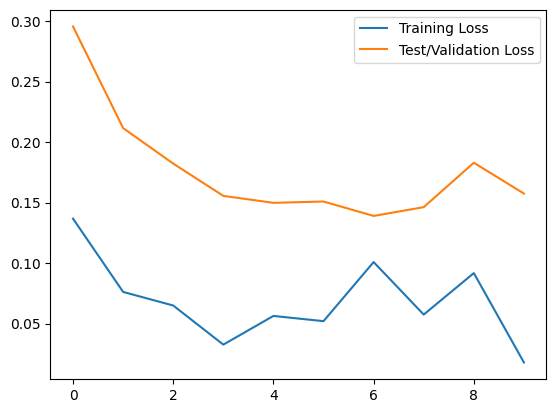

In [67]:
train_loss = [fl.item() for fl in train_losses]
test_loss = [fl.item() for fl in test_losses]
plt.plot(train_loss, label="Training Loss")
plt.plot(test_loss, label="Test/Validation Loss")
plt.legend()

In [73]:
train_acc = [t/600 for t in train_correct]

In [78]:
test_acc = [t/100 for t in test_correct]

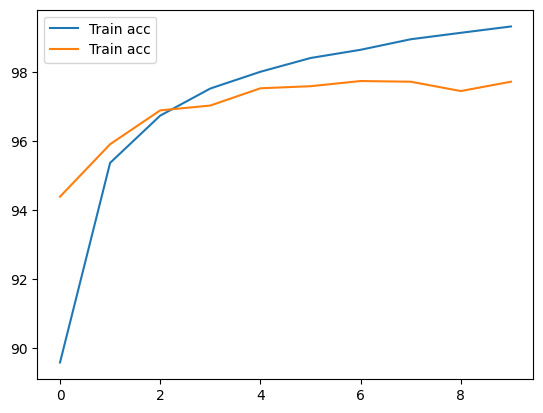

In [79]:
plt.plot(train_acc, label="Train acc")
plt.plot(test_acc, label="Train acc")
plt.legend()

In [80]:
# New Unseen Data
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [82]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test.view(len(X_test), -1))
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test).sum()


In [86]:
correct.item()/len(test_data) * 100

97.71

In [87]:
confusion_matrix(predicted.view(-1), y_test.view(-1))

array([[ 971,    0,    5,    0,    1,    2,    5,    2,    3,    2],
       [   0, 1124,    2,    0,    0,    0,    2,    8,    0,    2],
       [   0,    3, 1003,    2,    1,    0,    1,    9,    6,    0],
       [   1,    3,    5,  991,    0,   12,    1,    2,    4,    2],
       [   2,    0,    2,    0,  965,    3,    3,    6,    4,    8],
       [   0,    0,    0,    5,    0,  865,    4,    0,    3,    4],
       [   1,    2,    1,    0,    6,    2,  941,    0,    2,    0],
       [   1,    0,    4,    5,    0,    1,    0,  979,    2,    0],
       [   4,    3,   10,    3,    0,    5,    1,    3,  945,    4],
       [   0,    0,    0,    4,    9,    2,    0,   19,    5,  987]])